In [1]:
from quantplay.strategy.base import QuantplayAlgorithm
from quantplay.utils.constant import TickInterval
from quantplay.service import market
import pandas as pd


class Straddle(QuantplayAlgorithm):
    def __init__(self):
        self.interval = TickInterval.minute
        self.entry_time = "09:29"
        self.exit_time = "15:15"
        self.strategy_trigger_times = [self.entry_time]
        self.exchange_to_trade_on = "NFO"
        self.option_nearest_expiry_offset = 0
        self.option_chain_depth = 0
        self.stream_symbols_by_security_type = {"EQ": ["NIFTY BANK"]}
        self.strategy_type = "intraday"
        self.strategy_tag = "straddle"

        super(Straddle, self).__init__()

    def get_trades(self, market_data):
        equity_data = market_data[market_data.security_type == "EQ"]

        trades = market.get_trades(equity_data, entry_time_regex=self.entry_time)

        trades = self.add_expiry(trades, security_type="OPT")

        trades.loc[:, "atm_price"] = (
            round((trades.close / trades.strike_gap).astype(float)) * trades.strike_gap
        )
        trades.loc[:, "atm_price"] = trades.atm_price.astype(int)

        pe_trades = market.option_symbol(
            trades, price_column="atm_price", option_type="PE"
        )
        ce_trades = market.option_symbol(
            trades, price_column="atm_price", option_type="CE"
        )

        trades = pd.concat([pe_trades, ce_trades], axis=0)

        trades.loc[:, "transaction_type"] = "SELL"
        trades.loc[:, "stoploss"] = 0.5
        trades.loc[:, "quantity"] = 100

        return trades


In [2]:
strategy = Straddle()
strategy.validate()

Strategy with tag straddle successfully validated


Loading EQ data for 1 symbols
time taken to load data for minute candles --- 0.9005467891693115 seconds ---
Loading OPT data for 9058 symbols
time taken to load data for minute candles --- 2.6850979328155518 seconds ---


/Users/ashok/Library/Python/3.8/lib/python/site-packages/quantplay/services/market.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "date_only"] = pd.to_datetime(data.date.dt.date)


Loading OPT data for 34 symbols
time taken to load data for minute candles --- 0.10291934013366699 seconds ---
Dropping 4 trades because entry price is not available
Dropping 0 trades because close price is not available
Applying stoploss
   year        bps   monthly_pnl max_drawdown_days       max_drawdown  \
0   ALL -227.50207 -25142.277504                 7  55952.52107600002   
1  2022 -227.50207 -25142.277504                 7  55952.52107600002   

   sharpe_ratio  total_signals  success_ratio  exposure_90  total_profit  \
0     -8.224209             36       0.416667      89328.5 -25142.277504   
1     -8.224209             36       0.416667      89328.5 -25142.277504   

   unique_stocks  
0              1  
1              1  



POINT_DIFF ANALYSIS
             count       mean         std     min       25%     50%       75%  \
day_of_week                                                                     
Friday         6.0 -22.483333  186.513682 -236.85 -192.2875   6.675  1

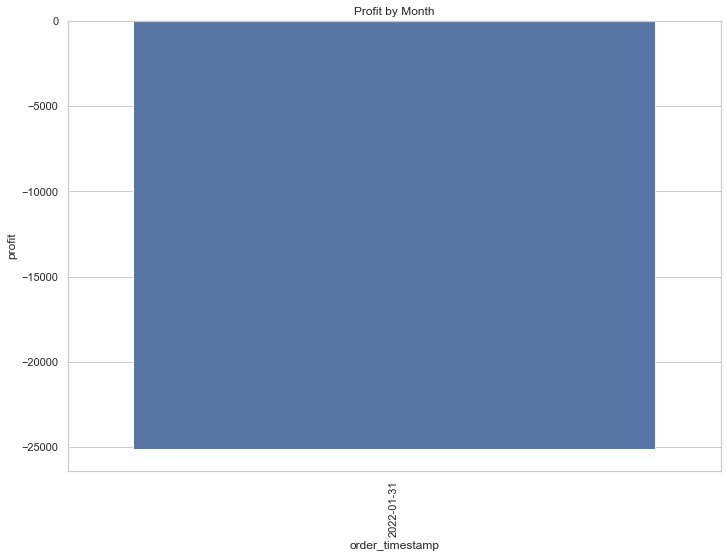

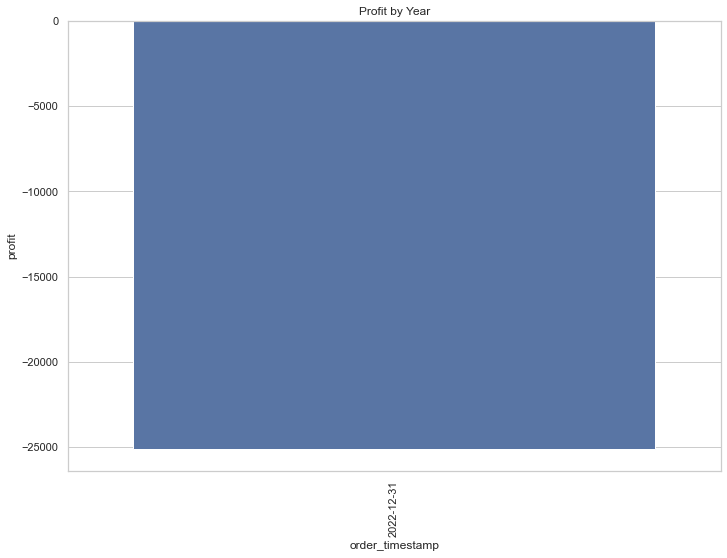

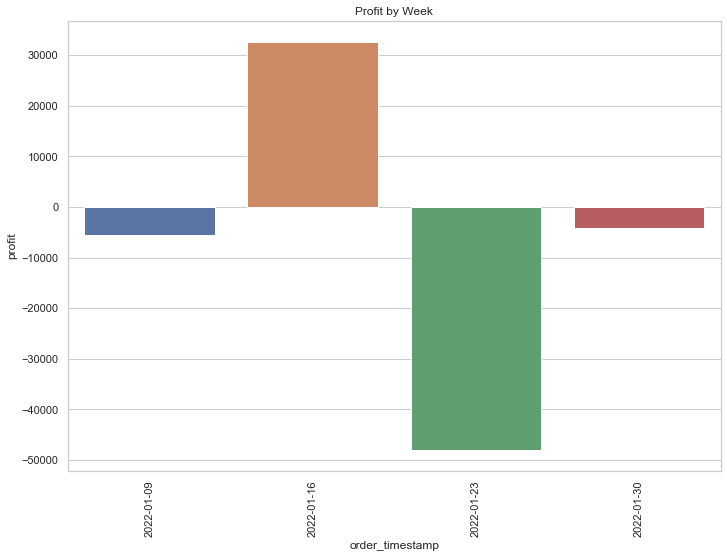

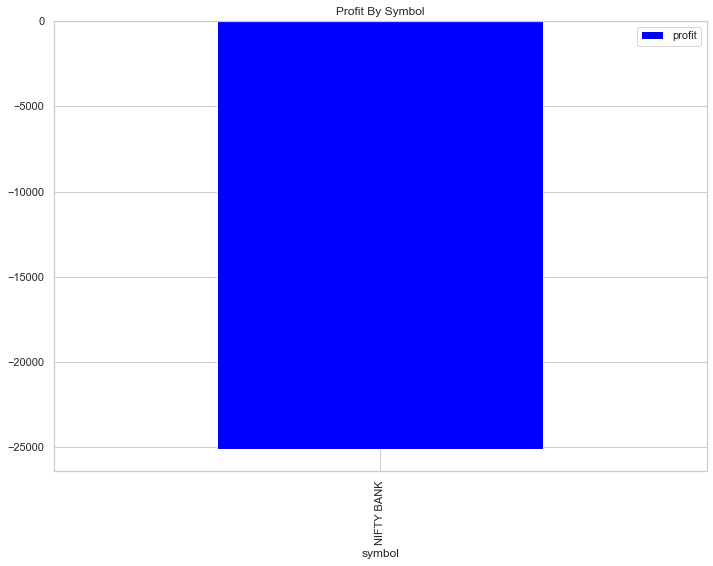

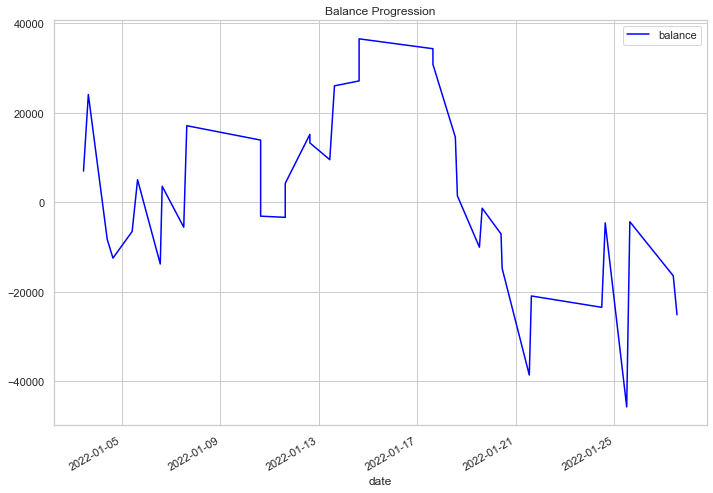

In [3]:
results, trades = strategy.backtest()